### Código + **Relatório**

**Aluno:** Savio Augusto Machado Araujo

Este notebook Python contém o código implementado juntamente do relatório, seguindo o padrão que cada célula de Markdown (como essa) refere-se diretamente à célula de código Python seguinte e seus resultados pós-execução, quando aplicável.

Primeiramente, para a implementação e avaliação da rede MLP serão usadas as bibliotecas Numpy e Matplotlib, para tratar respectivamente das partes matemática e gráfica. Além disso, como o funcionamento do modelo para regressão e para classificação será levemente diferente, foi implementada uma classe `Task` para agir apenas como um *enumerator* simples e *human-readable* para definir o tipo de tarefa da MLP em cada caso.

Ainda, para manter a modularidade da MLP a ser criada e também ajudar novamente no quesito *readability*, a função de ativação usada (sigmoide) e sua derivada foram implementadas como funções `lambda` para serem facilmente usadas dentro da implementação da MLP e/ou alteradas.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class Task:
    Regression = 0
    Classification = 1
    
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid_dx = lambda x: x * (1 - x)

Na classe `MLP` a seguir foi implementado todo o funcionamento da rede. Inicialmente pode-se destacar a inicialização da classe, começando por seus parâmetros:
- `task`: tarefa a ser executada pela rede, cujo tipo é o *enumerator* `Task`.
- `layers`: lista de inteiros, onde cada item representa uma camada e seu valor representa a quantidade de neurônios na camada. Com essa forma de implementação, a alteração da estrutura da rede ficará simplificada.
- `eta`: taxa de aprendizado da rede, define o tamanho dos "passos" dados no gradiente.
- `momentum`: define quanto da velocidade "acumulada" anteriormente será carregado na atualização atual.

Ademais, ao instanciar a classe `MLP` também são inicializadas para cada camada as listas de pesos, vieses e suas velocidades associadas. Para os pesos e vieses (`weights`, `biases`) os valores iniciais são aleatórios e para as velocidades (`velocities_w`, `velocities_b`) os valores iniciais são zero.

---

Já na função `forward` é performada a propagação pela rede computando as ativações de cada camada na lista `activations`. Aqui, para cada par de pesos e vieses o `z` é calculado como o produto vetorial entre cada peso `w` e a última ativação, então somando o viés `b`.

Vale notar que aqui pode-se ver o uso do atributo `task` definido anteriormente; no geral, todas as camadas ocultas foram implementadas com função de ativação sigmoide, porém na última camada toma-se uma abordagem diferente a depender da tarefa. Para a tarefa de regressão a ativação da última camada é linear, já para classificação a ativação permanece sigmoide (considerando o dataset escolhido e adaptado para classificação binária).

Houve uma tentativa de implementação da função de ativação softmax para ser usada na última camada em classificações, porém surgiram diversos problemas na consistência das saídas dos valores na lista de probabilidades softmax e não foi possível desenvolver uma forma funcional da rede com essa implementação; assim, foi mantido o sigmoide e a classificação binária.

---

Agora na função `backward`, é então performada a retropropagação na rede computando de trás para frente os gradientes com respeito aos pesos e vieses. Primeiramente são calculados os `deltas` brutos entre as ativações obtidas (`activations`) e os valores reais (`y`); então, da penúltima camada (última oculta) cada `delta` é calculado como o produto vetorial entre a transposta dos pesos da camada atual e o delta inicial da camada seguinte, então multiplicado pela derivada da função de ativação usada (sigmoide, nesse caso).

Com a lista `deltas` calculada, os gradientes dos pesos e dos vieses (`grad_w`, `grad_b`) são obtidos. Para os pesos de cada camada, produto vetorial entre deltas da camada atual e a transposta das ativações da camada, dividido pelo número de exemplos de entrada em `x`. Já para os vieses, o gradiente será o somatório dos deltas da camada atual dividido também pelo número de exemplos de entrada em `x`.

---

Na função `update_params` são aplicados os valores definidos de `eta` e `momentum`, ao se calcular e aplicar as velocidades. Para as velocidades (dos pesos e dos vieses) de cada camada, o momentum multiplica a velocidade acumulada até então e a taxa de aprendizado multiplica o gradiente correspondente obtido na retropropagação; as velocidades calculadas para os pesos e vieses da camada são então aplicadas aos mesmos.

---

Para a função `train` é importante notar que, além dos valores de entrada e da verdade (`X` e `Y`) é requisitado como parâmetro a quantidade total de épocas de treinamento (`epochs`) e, considerando esse total, a frequência de *report* do estado de treinamento (`verbose_freq`, reportar a cada N épocas).

Com as demais funções já implementadas, o processo de treinamento em si é simples:
1. obtém-se a lista de ativações de `forward`;
2. usando as ativações, obtém-se os gradientes de `backward`;
3. usando os gradientes, atualiza-se os parâmetros da rede com `update_params`;
4. repete-se os passos 1-3 até esgotar as épocas.

Portanto, a maior parte do código implementado na função `train` remete ao cálculo e *report* das perdas verificadas, usando-se novamente do atributo `task` para utilizar-se de perdas diferentes; para cada tarefa, foram implementas dois cálculos de perdas, uma de valor absoluto e outra em porcentagem.

Após pesquisa das melhores funções para calcular erro durante o treinamento em cada caso, foi adotado o MSE (Mean Square Error) e MAPE (Mean Absolute Percentage Error) para a tarefa de regressão e Binary Cross-Entropy e Accuracy para a tarefa de Classificação. O *report* é feito na primeira época, a cada N épocas (considerando `verbose_freq`) e na última época.

---

Por fim, a função `predict` é responsável pela predição dada uma nova entrada ´X´ e dada a rede já treinada, retornando o resultado numérico da predição conforme a última ativação na lista obtida. Em regressões o resultado será um valor contínuo sem necessidade de adaptações, enquanto em classificações binárias o resultado será 0 ou 1, adaptando a saída de probabilidade da função sigmoide para 1 se > 0.5 e 0 caso contrário.

In [3]:
class MLP:
    def __init__(self, *, task:Task, layers:list[int], eta=0.1, momentum=0.9):
        
        self.task = task
        self.layers = layers
        self.eta = eta
        self.momentum = momentum
        self.weights = []
        self.biases = []
        self.velocities_w = [] 
        self.velocities_b = []

        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i + 1], layers[i]) * 0.1)
            self.biases.append(np.random.randn(layers[i + 1], 1) * 0.1)
            self.velocities_w.append(np.zeros((layers[i + 1], layers[i])))
            self.velocities_b.append(np.zeros((layers[i + 1], 1)))


    def forward(self, x):
        activations = [x]

        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activations[-1]) + b
            
            if w is not self.weights[-1] or self.task == Task.Classification:
                activations.append(sigmoid(z))
            else:
                # última camada linear para regressão
                activations.append(z)
            
        return activations


    def backward(self, x, y, activations):
        deltas = [activations[-1] - y]

        for l in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(self.weights[l].T, deltas[0]) * sigmoid_dx(activations[l])
            deltas.insert(0, delta)

        grad_w = []
        grad_b = []
        for l in range(len(self.weights)):
            grad_w.append(np.dot(deltas[l], activations[l].T) / x.shape[1])
            grad_b.append(np.sum(deltas[l], axis=1, keepdims=True) / x.shape[1])

        return grad_w, grad_b


    def update_params(self, grad_w, grad_b):
        for l in range(len(self.weights)):
            self.velocities_w[l] = self.momentum * self.velocities_w[l] - self.eta * grad_w[l]
            self.velocities_b[l] = self.momentum * self.velocities_b[l] - self.eta * grad_b[l]

            self.weights[l] += self.velocities_w[l]
            self.biases[l] += self.velocities_b[l]


    def train(self, X, Y, epochs:int, verbose_freq:int):
        losses = []
        losses_perc = []
        for epoch in range(epochs):
            activations = self.forward(X)
            grad_w, grad_b = self.backward(X, Y, activations)
            self.update_params(grad_w, grad_b)

            # MSE e MAPE para regressão
            if self.task == Task.Regression:
                mse = np.mean((Y - activations[-1]) ** 2) 
                mape = np.mean(np.abs((Y - activations[-1]) / Y)) * 100
                losses.append(mse)
                losses_perc.append(mape)
                
                if epoch == epochs - 1 or epoch % verbose_freq == 0:
                    print(f"Epoch {epoch}\tMSE: {mse:.3f}\tMAPE: {mape:.3f}%")
                
            # Binary cross-entropy e Acurácia para classificação
            elif self.task == Task.Classification:
                activations_clip = np.clip(activations[-1], 1e-10, 1 - 1e-10)
                cross_entropy = -np.mean(Y * np.log(activations_clip) + (1 - Y) * np.log(1 - activations_clip))
                accuracy = np.mean((activations[-1] > 0.5) == Y) * 100
                losses.append(cross_entropy)
                losses_perc.append(accuracy)
                
                if epoch == epochs - 1 or epoch % verbose_freq == 0:
                    print(f"Epoch {epoch}\tCross-entropy: {cross_entropy:.3f}\tAccuracy: {accuracy:.3f}%")

        return losses, losses_perc


    def predict(self, X):
        activations = self.forward(X)
        if self.task == Task.Classification:
            return (activations[-1] > 0.5).astype(int)
        else:
            return activations[-1]

A função `split_data` foi implementada para simplificar o processo de divisão dos dados em conjuntos de treino e teste sob um *rate* de 80:20, embaralhando-os e então separando-os.

In [4]:
def split_data(data):
    np.random.shuffle(data)

    train_size = int(0.8 * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    return train_data, test_data

### Modelo de Exemplo - **XOR**

A fim de validar a nível básico o funcionamento correto da rede MLP implementada, segue um exemplo de aprendizado do problema da porta XOR. Como o problema é simples, é possível usar uma taxa de aprendizado elevada e confiar também em um momentum alto. Vê-se que a rede aprende com 100% de acurácia o problema simples e a saída no teste após o treinamento é [[0, 1, 1, 0]], ou seja, exatamente igual a `Y`.

In [31]:
# Exemplo XOR
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
Y = np.array([[0, 1, 1, 0]])
mlp = MLP(task=Task.Classification, layers=[2, 2, 1], eta=0.2, momentum=0.99)
losses, accuracies = mlp.train(X, Y, epochs=2000, verbose_freq=200)

predictions = mlp.predict(X)
print(predictions)

Epoch 0	Cross-entropy: 0.695	Accuracy: 50.000%
Epoch 200	Cross-entropy: 0.693	Accuracy: 50.000%
Epoch 400	Cross-entropy: 0.693	Accuracy: 50.000%
Epoch 600	Cross-entropy: 0.691	Accuracy: 50.000%
Epoch 800	Cross-entropy: 0.001	Accuracy: 100.000%
Epoch 1000	Cross-entropy: 0.000	Accuracy: 100.000%
Epoch 1200	Cross-entropy: 0.000	Accuracy: 100.000%
Epoch 1400	Cross-entropy: 0.000	Accuracy: 100.000%
Epoch 1600	Cross-entropy: 0.000	Accuracy: 100.000%
Epoch 1800	Cross-entropy: 0.000	Accuracy: 100.000%
Epoch 1999	Cross-entropy: 0.000	Accuracy: 100.000%
[[0 1 1 0]]


### Modelo de Regressão - **Treino**

Para o modelo de regressão foi utilizado um dataset de predição de tempo de sono (em horas), disponível no Kaggle [neste link](https://www.kaggle.com/datasets/govindaramsriram/sleep-time-prediction). Os dados possuem 7 colunas, sendo 6 delas (`WorkoutTime`, `ReadingTime`, `PhoneTime`, `WorkHours`, `CaffeineIntake`, `RelaxationTime`) delegadas para `X` e a última a ser predizida (`SleepTime`) para `Y`.

Apesar da maioria dos dados estar apresentado em horas/dia, o campo `CaffeineIntake` tem magnitude muito diferente dos demais pois é apresentado em mg/dia. Sendo assim, é aplicada uma normalização simples nos dados de cada coluna, a fim de que as magnitudes muito diferentes não atrapalhem o treinamento.

---

Com os dados prontos, a rede pode ser então treinada e testada. Foram treinados 9 modelos diferentes (tempo de execução de ~21 min) durante a mesma quantidade de épocas (100.000), combinando 3  estruturas diferentes de rede com 3 configurações de eta e momentum, definidas como:
|estrutura|
|---------|
|[6, 12, 6, 1]|
|[6, 12, 12, 6, 1]|
|[6, 12, 18, 12, 6, 1]|

|eta|momentum|
|---|--------|
|0.01|0.95|
|0.05|0.9|
|0.1|0.85|

A ideia das escolhas de taxa de aprendizagem (eta) e momentum segue que dando passos maiores é mais provável que acabe se tomando um salto mais "errado" no gradiente, portanto para tentar reduzir o poder desse passo de ser carregado nos próximos passos, aos passos maiores foram combinados momentums menores.

In [36]:
data = np.genfromtxt("sleeptime_prediction_dataset.csv", delimiter=",", skip_header=1)

# normalizar
data_mean = data.mean(axis=0)
data_std = data.std(axis=0)
data = (data - data_mean) / data_std

train_data, test_data = split_data(data)
X = train_data[:, 0:6].T
Y = train_data[:, 6:7].T

layers = [[6, 12, 6, 1], [6, 12, 12, 6, 1], [6, 12, 18, 12, 6, 1]]
etas = [0.01, 0.05, 0.1]
momentums = [0.95, 0.9, 0.85]

mses = []
mapes = []
models = []

i = 1
for l in layers:
    for eta, momentum in zip(etas, momentums):
        print(f"Model {i} - Layers: {l} - Eta: {eta} - Momentum: {momentum}")
        mlp = MLP(
            task=Task.Regression,
            layers=l, 
            eta=eta,
            momentum=momentum)

        mse, mape = mlp.train(
            X, Y,
            epochs=100000,
            verbose_freq=1000)
        
        models.append(mlp)
        mses.append(mse)
        mapes.append(mape)
        i += 1


Model 1 - Layers: [6, 12, 6, 1] - Eta: 0.01 - Momentum: 0.95
Epoch 0	MSE: 1.087	MAPE: 186.658%
Epoch 1000	MSE: 0.790	MAPE: 127.982%
Epoch 2000	MSE: 0.790	MAPE: 129.793%
Epoch 3000	MSE: 0.788	MAPE: 129.432%
Epoch 4000	MSE: 0.783	MAPE: 129.116%
Epoch 5000	MSE: 0.778	MAPE: 130.085%
Epoch 6000	MSE: 0.776	MAPE: 130.750%
Epoch 7000	MSE: 0.775	MAPE: 131.593%
Epoch 8000	MSE: 0.774	MAPE: 132.829%
Epoch 9000	MSE: 0.773	MAPE: 134.102%
Epoch 10000	MSE: 0.771	MAPE: 135.339%
Epoch 11000	MSE: 0.770	MAPE: 136.523%
Epoch 12000	MSE: 0.769	MAPE: 137.623%
Epoch 13000	MSE: 0.768	MAPE: 138.780%
Epoch 14000	MSE: 0.767	MAPE: 139.891%
Epoch 15000	MSE: 0.766	MAPE: 140.894%
Epoch 16000	MSE: 0.765	MAPE: 141.675%
Epoch 17000	MSE: 0.764	MAPE: 142.004%
Epoch 18000	MSE: 0.763	MAPE: 142.030%
Epoch 19000	MSE: 0.762	MAPE: 143.486%
Epoch 20000	MSE: 0.761	MAPE: 145.377%
Epoch 21000	MSE: 0.760	MAPE: 147.244%
Epoch 22000	MSE: 0.759	MAPE: 149.063%
Epoch 23000	MSE: 0.757	MAPE: 150.828%
Epoch 24000	MSE: 0.755	MAPE: 153.149%
Ep

Com os 9 modelos treinados, é possível então avaliar os resultados obtidos após o treinamento. Primeiramente é apresentada uma tabela que relaciona um ID de 1 a 9 a cada configuração de modelo e seus respectivos resultados de MSE e MAPE; em seguida, são apresentados gráficos para MSE e MAPE ao longo do treinamento, agrupando os pares de gráficos pela estrutura (número de camadas) dos modelos para facilitar a visualização e avaliação. Sendo assim, cada gráfico representa uma estrutura de rede e cada uma das 3 curvas representa um par de eta e momentum aplicado naquela estrutura.

---

Primeiramente, os modelos de 4 camadas aparentam ser muito simples para aprender o problema visto que seu MAPE final de treino foi acima de 100% em todos os casos, e mesmo que consideremos seu melhor MAPE ao longo do treinamento (modelo 2, épocas 30k-35k) ele nao cai muito abaixo dos 80%  e o MSE correspondente continua alto se comparado ao das outras estruturas. Além disso, vê-se que sob um passo maior (eta 0.1, modelo 3) essa estrutura acaba até se perdendo do progresso obtido, saindo da área que conseguiu descer no gradiente e variando drasticamente sem conseguir se recuperar.

---

É possível verificar claramente que os modelos de 5 camadas têm os melhores resultados gerais durante o treinamento, dadas as três combinações de eta e momentum. Considerando o modelo 4 de passo pequeno, mesmo com o momento alto os resultados gráficos indicam que ainda seriam necessárias muito mais épocas para este alcançar um resultado bom. Conforme aumenta-se a taxa de aprendizagem e reduz-se levemente o momento nos modelos 5 e 6 obtém-se um melhor resultado mais rápido, com o modelo 6 alcançando um MAPE final de 45.6%. Apesar desse ser o melhor resultado geral ele ainda é alto, porém ainda falamos de treino; O ojbetivo é que esses modelos performem com um MAPE baixo realmente no teste executado mais à frente. No geral, essa estrutura aparenta ser a mais adequada para o problema, sendo a mais simples que apresenta resultados promissores.

--- 

Por fim, para os modelos de 6 camadas observa-se que a estrutura é sim capaz de aprender o problema a certo nível, o que era esperado já que 5 camadas alcançaram isso. Porém, em todos os casos 6 camadas performaram pior que 5, e tanto o MSE quanto o MAPE flutuaram ferozmente durante o treino ainda que os resultados finais indiquem algum aprendizado. É possível observar que o modelo 7 (eta 0.05, momentum 0.9) foi o melhor caso dessa estrutyura, portanto para modelos mais complexos a sensibilidade é maior, visto que não só passos menores (0.01) demandarão muito mais tempo como passos maiores (0.1) acabam não sendo muito eficientes.

Model	Layers	Eta	Momnt.	MSE	MAPE
1	4	0.01	0.95	0.315	119.268
2	4	0.05	0.9	0.238	112.324
3	4	0.1	0.85	0.255	114.366
4	5	0.01	0.95	0.279	105.104
5	5	0.05	0.9	0.096	61.333
6	5	0.1	0.85	0.053	45.654
7	6	0.01	0.95	0.416	117.034
8	6	0.05	0.9	0.066	71.342
9	6	0.1	0.85	0.075	82.084


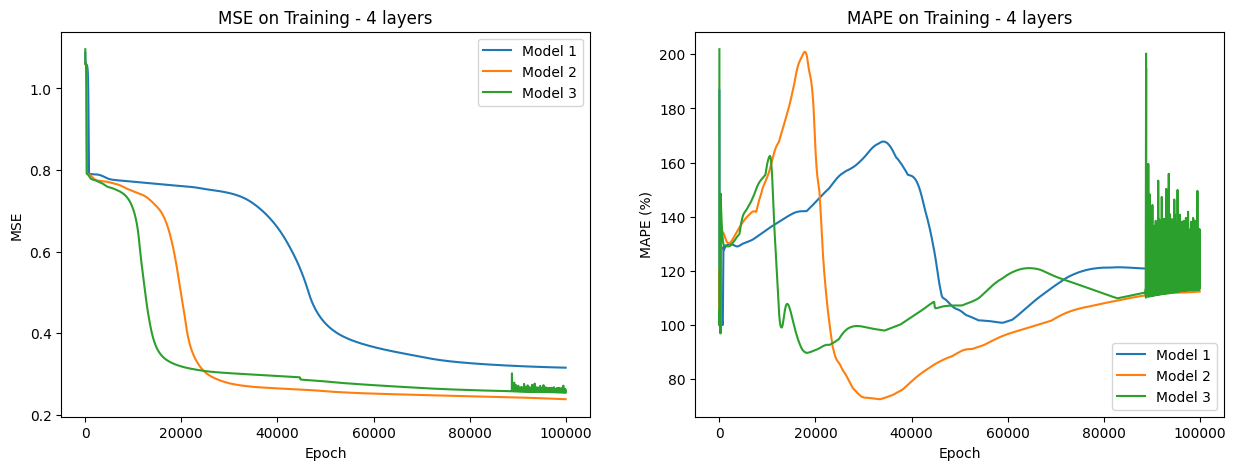

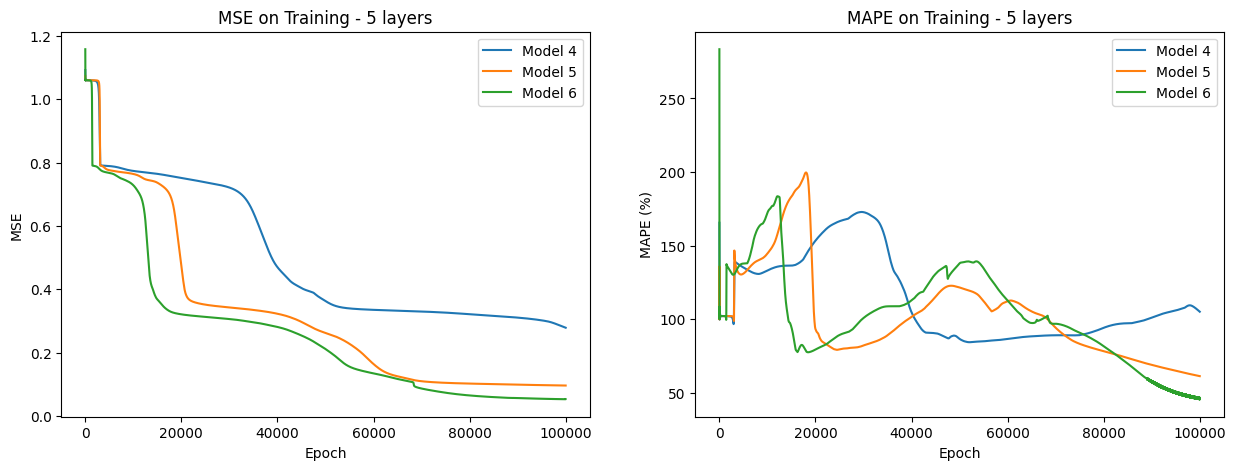

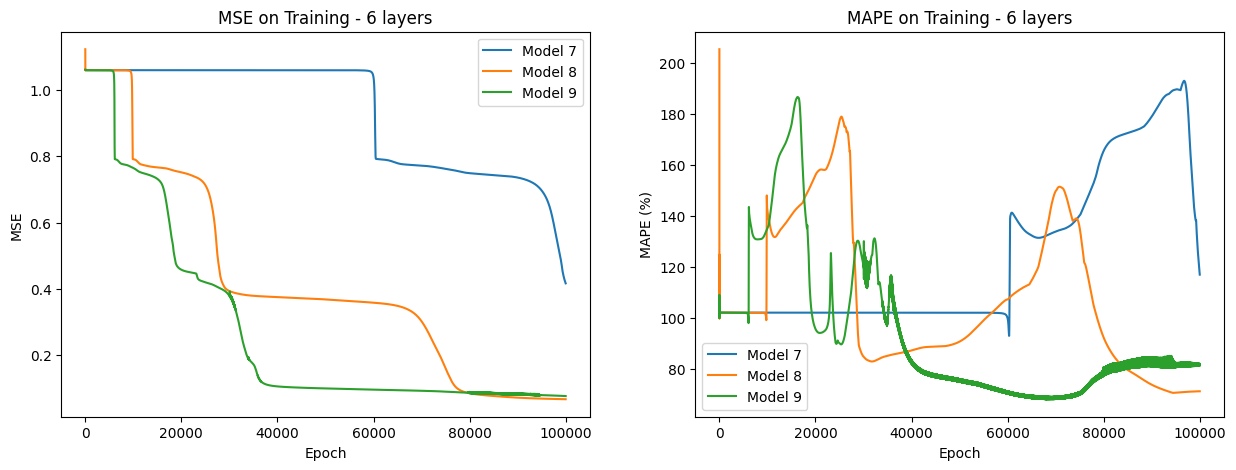

In [ ]:
i = 0     
print("Model\tLayers\tEta\tMomnt.\tMSE\tMAPE")
for l in layers:
    for eta, momentum in zip(etas, momentums):
        print(f"{i+1}\t{len(l)}\t{eta}\t{momentum}\t{mses[i][-1]:.3f}\t{mapes[i][-1]:.3f}")
        i += 1

for group in range(3):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for i in range(group * 3, (group + 1) * 3):
        plt.plot(mses[i], label=f"Model {i+1}")
    plt.title(f"MSE on Training - {len(layers[group])} layers")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i in range(group * 3, (group + 1) * 3):
        plt.plot(mapes[i], label=f"Model {i+1}")
    plt.title(f"MAPE on Training - {len(layers[group])} layers")
    plt.xlabel("Epoch")
    plt.ylabel("MAPE (%)")
    plt.legend()
    plt.show()
    

### Modelo de Regressão - **Teste**

Com cada modelo treinado e revisado, pode-se então partir para os testes com a fração de 20% dos dados separados para tal. Para cada modelo são entregues os mesmos dados de teste, não vistos no treino, e são obtidas as predições para que se possa calcular MSE e MAPE do teste.

Os resultados obtidos e mostrados na tabela foram um tanto quanto inesperados para os modelos estruturalmente mais simples, dados os gráficos vistos anteriormente durante os treinamentos. Ainda mantém-se o modelo 6 como o melhor em termos de erro percentual, obtendo um MAPE de apenas 12.7%, porém as diferenças são bem menos expressivas; os modelos de 4 camadas, especialmente o modelo 1 não ficam muito atrás, alcançando 14.1% de erro e com MSE similar. Os resultados levaram à uma revisão dos métodos de cálculo das métricas de erro, incluindo verificação das predições individuais vs valores reais (trecho de código comentado, dado o volume de prints).

Um comportamento que também pode ser observado é que os modelos de 5 camadas se beneficiaram de um passo maior (e momento ajustado ao passo), enquanto para 4 ou 6 camadas os passos maiores causaram instabilidade e consequentemente erros maiores; o modelo 9 de 6 camadas, por exemplo, apresentou o maior MAPE com 24.4%.

---

Com isso, para escolher a melhor performance devemos primeiramente escolher o que priorizar. Pode-se dizer que dados os resultados dos testes os modelos de 6 camadas (modelos 7 a 9) ficam fora de questão, considerando seus resultados piores quando pesados juntos de sua estrutura mais complexa e consequente maior tempo de treinamento.

Já para 4 e 5 camadas podemos escolher os melhores quanto à % de acerto, considerando `100% - MAPE`; assim, tomamos os modelos 1 e 6. Aqui seria comumente mais conveniente adota ro modelo mais simples que está mais próxim ode resolver o problema, e como a diferença percentual de acerto entre os modelos 1 e 6 é de menos de 2%, pode-se adotar o modelo 1 (de 4 camadas) para futuros aprimoramentos. Apesar disso, o comportamento positivo do modelo 6 quanto às maiores taxas de treinamento também é um fator interessante a ser considerado.

In [56]:
X = test_data[:, 0:6].T
Y = test_data[:, 6:7].T

# desnormalizar
Y = Y * data_std[6] + data_mean[6]

mses = []
mapes = []
for mlp in models:
    predictions = mlp.predict(X)

    # desnormalizar
    predictions = predictions * data_std[6] + data_mean[6]

    mse = np.mean((Y - predictions) ** 2)
    mape = np.mean(np.abs((Y - predictions) / Y)) * 100
    mses.append(mse)
    mapes.append(mape)
    # for prediction, actual in zip(predictions[0], Y[0]):
    #     print(f"Predicted: {prediction:.2f} hours\tActual: {actual:.2f} hours")
    
i = 0   
print("Model\tLayers\tEta\tMomnt.\tMSE\tMAPE")
for l in layers:
    for eta, momentum in zip(etas, momentums):
        print(f"{i+1}\t{len(l)}\t{eta}\t{momentum}\t{mses[i]:.3f}\t{mapes[i]:.3f}")
        i += 1

Model	Layers	Eta	Momnt.	MSE	MAPE
1	4	0.01	0.95	7.210	14.104
2	4	0.05	0.9	6.659	17.829
3	4	0.1	0.85	10.560	16.101
4	5	0.01	0.95	7.753	17.036
5	5	0.05	0.9	9.735	16.954
6	5	0.1	0.85	6.837	12.779
7	6	0.01	0.95	3.583	13.398
8	6	0.05	0.9	7.130	15.048
9	6	0.1	0.85	13.663	24.359


### Modelo de Classificação - **Treino**

Para o modelo de classificação foi utilizado um dataset de predição de qualidade do ar (em classes), disponível no Kaggle [neste link](https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment). Os dados possuem 10 colunas, sendo 9 delas (`Temperature`, `Humidity`, `PM2.5`, `PM10`, `NO2`, `SO2`, `CO`, `Proximity_to_Industrial_Areas`, `Population_Density`) delegadas para `X` e a última a ser predizida (`Air Quality`) para `Y`. Os dados de qualidade foram reduzidos a duas classes (qualidades ruim e aceitável) para a classificação binária.

Como os campos possuem diversas unidades e magnitudes diferentes, é aplicada uma normalização simples nos dados de cada coluna a fim de que as magnitudes muito diferentes não atrapalhem o treinamento.

---

Seguindo o mesmo formato anterior, foram treinados 9 modelos diferentes (tempo de execução de ~27 min) durante a mesma quantidade de épocas (50.000), combinando 3  estruturas diferentes de rede com 3 configurações de eta e momentum, definidas como:
|estrutura|
|---------|
|[9, 18, 1]|
|[9, 18, 18, 1]|
|[9, 18, 27, 18, 1]|

|eta|momentum|
|---|--------|
|0.01|0.95|
|0.05|0.9|
|0.1|0.85|

In [58]:
data = np.genfromtxt("updated_pollution_dataset.csv", delimiter=",", skip_header=1)

train_data, test_data = split_data(data)
X = train_data[:, 0:9].T
Y = train_data[:, 9:10].T

# normalizar
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

layers = [[9, 18, 1], [9, 18, 18, 1], [9, 18, 27, 18, 1]]
etas = [0.01, 0.05, 0.1]
momentums = [0.95, 0.9, 0.85]

cross_entropies = []
accuracies = []
models = []

i = 1
for l in layers:
    for eta, momentum in zip(etas, momentums):
        print(f"Model {i} - Layers: {l} - Eta: {eta} - Momentum: {momentum}")
        mlp = MLP(
            task=Task.Classification,
            layers=l, 
            eta=eta,
            momentum=momentum)

        cross_entropy, accuracy = mlp.train(
            X, Y,
            epochs=50000,
            verbose_freq=1000)
        
        models.append(mlp)
        cross_entropies.append(cross_entropy)
        accuracies.append(accuracy)
        i += 1

Model 1 - Layers: [9, 18, 1] - Eta: 0.01 - Momentum: 0.95
Epoch 0	Cross-entropy: 0.786	Accuracy: 29.500%
Epoch 1000	Cross-entropy: 0.593	Accuracy: 70.500%
Epoch 2000	Cross-entropy: 0.531	Accuracy: 72.850%
Epoch 3000	Cross-entropy: 0.474	Accuracy: 75.525%
Epoch 4000	Cross-entropy: 0.406	Accuracy: 80.800%
Epoch 5000	Cross-entropy: 0.349	Accuracy: 84.850%
Epoch 6000	Cross-entropy: 0.319	Accuracy: 86.325%
Epoch 7000	Cross-entropy: 0.302	Accuracy: 86.675%
Epoch 8000	Cross-entropy: 0.292	Accuracy: 87.050%
Epoch 9000	Cross-entropy: 0.285	Accuracy: 87.375%
Epoch 10000	Cross-entropy: 0.279	Accuracy: 87.625%
Epoch 11000	Cross-entropy: 0.274	Accuracy: 87.975%
Epoch 12000	Cross-entropy: 0.269	Accuracy: 88.250%
Epoch 13000	Cross-entropy: 0.265	Accuracy: 88.675%
Epoch 14000	Cross-entropy: 0.261	Accuracy: 88.800%
Epoch 15000	Cross-entropy: 0.257	Accuracy: 89.200%
Epoch 16000	Cross-entropy: 0.253	Accuracy: 89.275%
Epoch 17000	Cross-entropy: 0.250	Accuracy: 89.500%
Epoch 18000	Cross-entropy: 0.246	Accu

Seguindo o mesmo formato já visto, primeiramente é apresentada uma tabela que relaciona um ID de 1 a 9 a cada configuração de modelo e seus respectivos resultados de Binary Cross-Entropy e Accuracy; em seguida, são apresentados gráficos para Cross-Entropy e Accuracy ao longo do treinamento, agrupando os pares de gráficos pela estrutura (número de camadas) dos modelos para facilitar a visualização e avaliação. Sendo assim, cada gráfico representa uma estrutura de rede e cada uma das 3 curvas representa um par de eta e momentum aplicado naquela estrutura.

---

Para a classificação pode-se verificar claramente que as diferenças de Accuracy entre todos os 9 modelos se apresenta praticamente irrisória, e a diferença de Cross-Entropy não varia em grande quantidade através das configurações de rede. Porém ao olhar par aos gráficos fica vísivel que o comportamento durante o treinamento se apresentou de forma muito mais "caótica" quanto mais complexa é a estrutura da rede; isso aumenta de forma correlata com a taxa de aprendizagem, mostrando que as redes mais complexas têm mais dificuldade em manter passos consistentes no processo convergência para se aproximarem da resolução do problema.

Ainda assim, se tem algo que foi aprendido no modelo de regressão é que os resultados do treino não podem ser tomados como grandes indicadores do comportamento final, apesar das altas acurácias observadas, portanto uma melhor avaliação de cada modelo será dissertada após os resultados obtidos do conjunto de teste.

Model	Layers	Eta	Momnt.	Cr.ent.	Accuracy
1	3	0.01	0.95	0.215	92.150
2	3	0.05	0.9	0.210	92.075
3	3	0.1	0.85	0.207	92.225
4	4	0.01	0.95	0.199	92.425
5	4	0.05	0.9	0.192	92.775
6	4	0.1	0.85	0.198	92.475
7	5	0.01	0.95	0.201	92.425
8	5	0.05	0.9	0.184	92.825
9	5	0.1	0.85	0.176	93.000


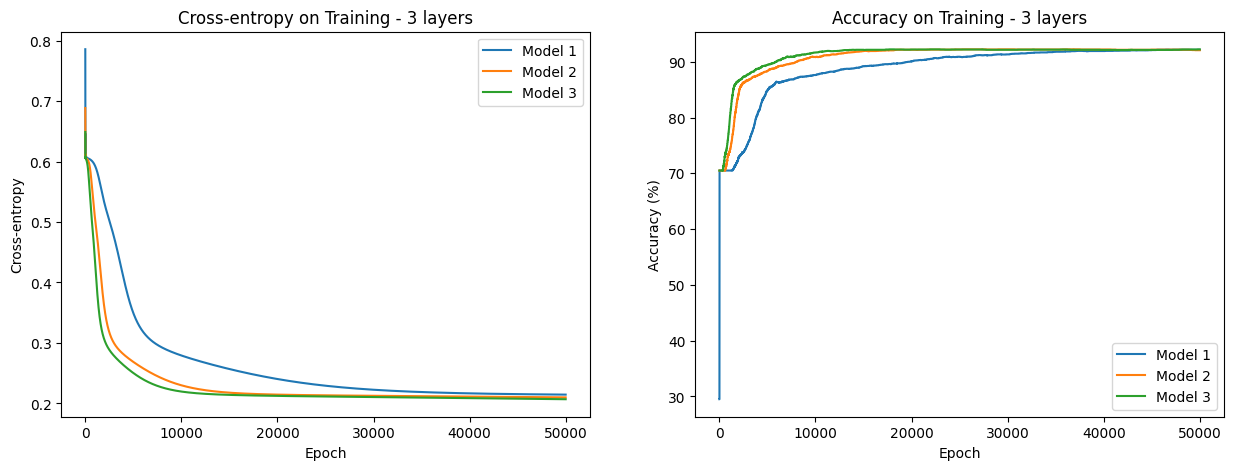

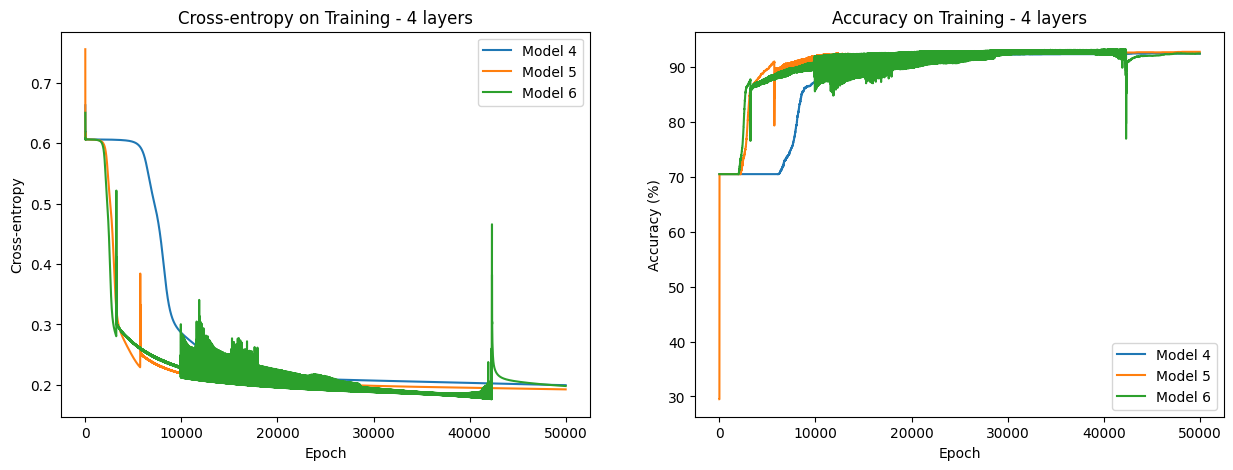

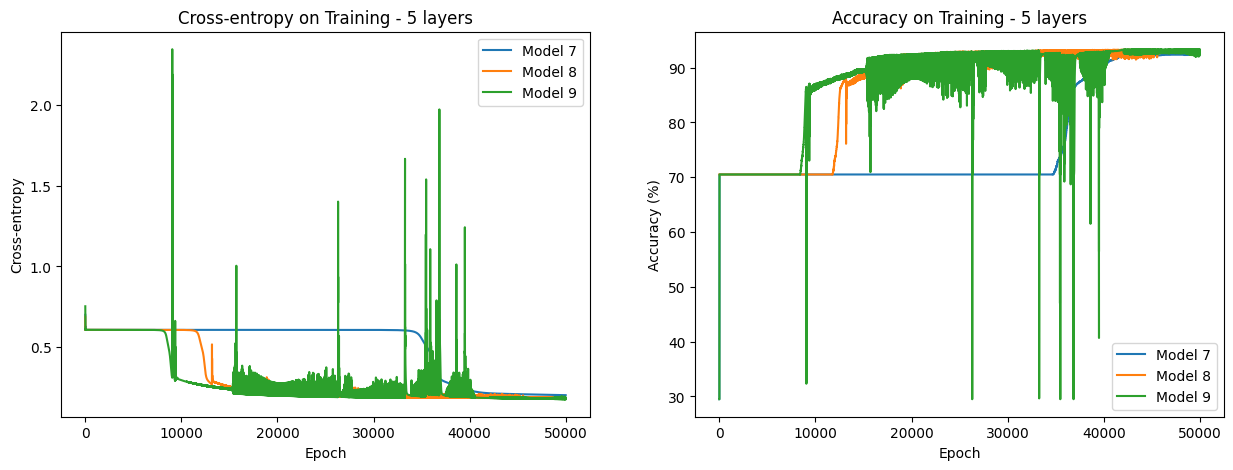

In [60]:
i = 0
print("Model\tLayers\tEta\tMomnt.\tCr.ent.\tAccuracy")
for l in layers:
    for eta, momentum in zip(etas, momentums):
        print(f"{i+1}\t{len(l)}\t{eta}\t{momentum}\t{cross_entropies[i][-1]:.3f}\t{accuracies[i][-1]:.3f}")
        i += 1
        
for group in range(3):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    for i in range(group * 3, (group + 1) * 3):
        plt.plot(cross_entropies[i], label=f"Model {i+1}")
    plt.title(f"Cross-entropy on Training - {len(layers[group])} layers")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for i in range(group * 3, (group + 1) * 3):
        plt.plot(accuracies[i], label=f"Model {i+1}")
    plt.title(f"Accuracy on Training - {len(layers[group])} layers")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.show()

### Modelo de Classificação - **Teste**

Com a execução dos testes utilizando a fração de 20% separada para tal, obtém-se os resultados apresentados na tabela. Percebe-se primeiramente que os resultados aqui na classificação se mantém mais consistentes com os do treinamento, diferente do modelo de regressão. Para todo caso, os resultados obtidos possuem diferenças irrisórias na prática, portanto é mais simples escolhe ro modelo mais conveniente; o mais simples que melhor resolve o problema. Os modelos de 3 camadas (1 a 3) apresentam resultados similares, sendo o modelo 3 marginalmente melhor. Ainda, como a convergência parece ocorrer de forma suave nos três casos, pode-se adotar o modelo 3 por sua taxa de aprendizagem maior, a fim de otimizar seus parâmetros. 

In [63]:
X = test_data[:, 0:9].T
Y = test_data[:, 9:10].T

# normalizar
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

cross_entropies = []
accuracies = []

for mlp in models:
    predictions = mlp.predict(X)

    cross_entropy = -np.mean(Y * np.log(predictions + 1e-10) + (1 - Y) * np.log(1 - predictions + 1e-10))
    accuracy = np.mean((predictions > 0.5) == Y) * 100
    cross_entropies.append(cross_entropy)
    accuracies.append(accuracy)
    
i = 0
print("Model\tLayers\tEta\tMomnt.\tCr.ent.\tAccuracy")
for l in layers:
    for eta, momentum in zip(etas, momentums):
        print(f"{i+1}\t{len(l)}\t{eta}\t{momentum}\t{cross_entropies[i]:.3f}\t{accuracies[i]:.3f}")
        i += 1

Model	Layers	Eta	Momnt.	Cr.ent.	Accuracy
1	3	0.01	0.95	2.164	90.600
2	3	0.05	0.9	2.141	90.700
3	3	0.1	0.85	2.118	90.800
4	4	0.01	0.95	2.049	91.100
5	4	0.05	0.9	2.049	91.100
6	4	0.1	0.85	2.072	91.000
7	5	0.01	0.95	2.072	91.000
8	5	0.05	0.9	2.003	91.300
9	5	0.1	0.85	1.842	92.000
